## KR260 HLS Configurable Fixed Gain with AXI Streaming Interface
This tutorial demonstrates how to accelerate a Python function on the KR260 using PYNQ, and how to interface with a Vitis HLS modules which has a AXI Streaming interface with an AXI Lite interface for Status/Control

### Plot function for use in this notebook
The first code block below defines a function that we will use for plotting data throughout this notebook. Note that the function has a `n_samples` argument so that we can limit the number of samples to plot. Plotting more than a few thousand samples can be very slow and consume a lot of RAM.

### Requirements
Install the following:

pip install ipympl

pip install ipywidgets


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec,in_signal,n_samples,out_signal=None):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-',label='Input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_signal[:n_samples],'g-',linewidth=2,label='Gain output')
    plt.legend()

### Generate the input signal

Number of samples:  2000


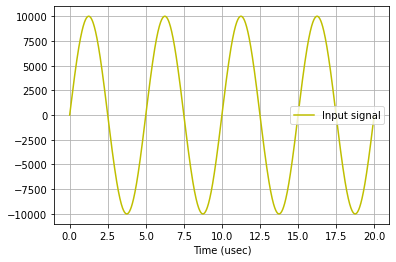

In [100]:
import numpy as np

# Total time
T = 0.00002
# Sampling frequency
fs = 100e6
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)
# Samples of the signal
samples = 10000*np.sin(0.2e6*2*np.pi*t) # + 1500*np.cos(46e6*2*np.pi*t) + 2000*np.sin(12e6*2*np.pi*t)
# Convert samples to 32-bit integers
samples = samples.astype(np.int32)
print('Number of samples: ',len(samples))

# Plot signal to the notebook
plot_to_notebook(t,samples,len(samples))

### Hardware HLS Gain Block Implementation

In [101]:
from pynq import Overlay
from pynq import allocate
import pynq.lib.dma

# Load the overlay
overlay = Overlay('/home/root/jupyter_notebooks/kr260_hls_fixed_gain_stream/kr260_hls_fixed_gain_stream.bit')

# Load the FIR DMA
dma = overlay.axi_dma_0
hls_gain_map = overlay.axi_fixed_gain_stream_0.register_map
hls_gain_reg = overlay.axi_fixed_gain_stream_0

### Print out the register map for DMA and HLS Gain Blocks

In [ ]:
overlay.ip_dict

In [ ]:
dma.register_map

In [ ]:
hls_gain_map

In [ ]:
print("Data Size     : ",str(n))

### Now to Transfer the Sinewave to the FPGA HLS Gain Block

Start Time                 :  1682479821.710769
Submit sending the transfer into in_buffer
Submit receiving the transfer from out_buffer
Done Sending the transfer to in_buffer
Done receiving the transfer from out_buffer
Hardware FIR execution time:  0.0040547847747802734


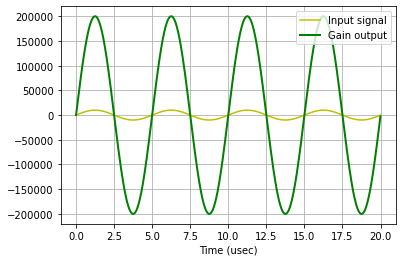

In [103]:
# Configure Control Register to Auto-Restart
hls_gain_reg.write(0x0,0x81)

# Configure Gain Register
hls_gain_map.gain = 20

# Allocate buffers for the input and output signals
in_buffer = allocate(shape=(n,), dtype=np.int32)
out_buffer = allocate(shape=(n,), dtype=np.int32)

# Copy the samples to the in_buffer
np.copyto(in_buffer,samples)

# Trigger the DMA transfer and wait for the result
import time
start_time = time.time()
print('Start Time                 : ',start_time)
dma.sendchannel.transfer(in_buffer)
print('Submit sending the transfer into in_buffer')
dma.recvchannel.transfer(out_buffer)
print('Submit receiving the transfer from out_buffer')
dma.sendchannel.wait()
print('Done Sending the transfer to in_buffer')
dma.recvchannel.wait()
print('Done receiving the transfer from out_buffer')
stop_time = time.time()
hw_exec_time = stop_time-start_time

print('Hardware FIR execution time: ',hw_exec_time)


# Plot to the notebook
plot_to_notebook(t,samples,len(out_buffer),out_signal=out_buffer)

# Free the buffers
in_buffer.close()
out_buffer.close()

In [ ]:
del in_buffer, out_buffer